Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# Tutorial #1: Train an binary classification model with Azure Machine Learning

In this tutorial, you train a machine learning model on remote compute resources. You'll use the training and deployment workflow for Azure Machine Learning service (preview) in a Python Jupyter notebook.  You can then use the notebook as a template to train your own machine learning model with your own data. This tutorial is **part one of a two-part tutorial series**.  

This tutorial trains a simple logistic regression using the bike buyer dataset and [scikit-learn](http://scikit-learn.org) with Azure Machine Learning.  

Learn how to:

> * Set up your development environment
> * Access and examine the data
> * Train a simple logistic regression model on a remote VM
> * Review training results, find and register the best model

You'll learn how to select a model and deploy it in [part two of this tutorial](deploy-models.ipynb) later. 

## Prerequisites

See prerequisites in the [Azure Machine Learning documentation](https://docs.microsoft.com/azure/machine-learning/service/tutorial-train-models-with-aml#prerequisites).

## Set up your development environment

All the setup for your development work can be accomplished in a Python notebook.  Setup includes:

* Importing Python packages
* Connecting to a workspace to enable communication between your local computer and remote resources
* Creating an experiment to track all your runs
* Creating a remote compute target to use for training

### Import packages

Import Python packages you need in this session. Also display the Azure Machine Learning SDK version.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import azureml.core
from azureml.core import Workspace

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.0.83


In [ ]:
!pip install category_encoders

### Connect to workspace

Create a workspace object from the existing workspace. `Workspace.from_config()` reads the file **config.json** and loads the details into an object named `ws`.

In [2]:
# load workspace configuration from the config.json file in the current folder.
ws = Workspace.from_config()
print(ws.name, ws.location, ws.resource_group, sep='\t')

Performing interactive authentication. Please follow the instructions on the terminal.
To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code A8Z8FFX6J to authenticate.


WARNING - Failed to authenticate '{'additional_properties': {}, 'id': '/tenants/35cd3241-d250-4a26-93c8-ee676440a2b7', 'tenant_id': '35cd3241-d250-4a26-93c8-ee676440a2b7'}' due to error 'Get Token request returned http error: 400 and server response: {"error":"interaction_required","error_description":"AADSTS50076: Due to a configuration change made by your administrator, or because you moved to a new location, you must use multi-factor authentication to access '797f4846-ba00-4fd7-ba43-dac1f8f63013'.\r\nTrace ID: c2303794-dfda-472c-b8eb-75e780532200\r\nCorrelation ID: 51b4eb6a-e469-4917-9f7e-27d8689f5081\r\nTimestamp: 2020-03-02 13:18:29Z","error_codes":[50076],"timestamp":"2020-03-02 13:18:29Z","trace_id":"c2303794-dfda-472c-b8eb-75e780532200","correlation_id":"51b4eb6a-e469-4917-9f7e-27d8689f5081","error_uri":"https://login.microsoftonline.com/error?code=50076","suberror":"basic_action"}'


Interactive authentication successfully completed.
aiadjacent	eastus	robotairg


### Create experiment

Create an experiment to track the runs in your workspace. A workspace can have muliple experiments. 

In [3]:
experiment_name = 'sklearn-bikebuyer'

from azureml.core import Experiment
exp = Experiment(workspace=ws, name=experiment_name)

You now have the necessary packages and compute resources to train a model in the cloud. 

## Explore data

Before you train a model, you need to understand the data that you are using to train it. In this section you learn how to:

* Download the bikebuyer dataset
* Display sample dataframe
* Explore the data

### Download the bikebuyer dataset

This code retrieves the data as a `Dataset` object. The 'Dataset' class provides you with the ability to download or mount the files to your compute by creating a reference to the data source location. Additionally, you register the Dataset to your workspace for easy retrieval during training.

Follow the [how-to](https://aka.ms/azureml/howto/createdatasets) to learn more about Datasets and their usage in the SDK.

In [40]:
from azureml.core import Workspace, Datastore, Dataset

# datastore_name = 'aiadjacentdatastore' #Name your datastore here
# retrieve an existing datastore in the workspace by name
# datastore = Datastore.get(workspace, datastore_name)

# get existing workspace
workspace = Workspace.from_config()  #config file is already saved locally when using this interface

dataset = Dataset.get_by_name(workspace, name='BikeBuyerTraining')
df=dataset.to_pandas_dataframe()

### Display the dataframe

In [41]:
df.head()

,Age,MaritalStatus,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,Education,Occupation,HouseOwnerFlag,NumberCarsOwned,StateProvinceCode,PostalCode,BikeBuyer
0,41,M,F,100000.0,2,0,Bachelors,Management,1,2,WA,98312.0,0
1,41,M,M,100000.0,2,0,Bachelors,Management,1,3,OR,97355.0,0
2,47,S,F,100000.0,3,0,Bachelors,Management,0,3,WA,98052.0,0
3,36,S,F,30000.0,0,0,Partial College,Skilled Manual,0,1,CA,91502.0,1
4,36,M,M,30000.0,0,0,Partial College,Skilled Manual,1,1,CA,91932.0,1


In [47]:
df.dtypes

Age                       int64
MaritalStatus            object
Gender                   object
YearlyIncome            float64
TotalChildren             int64
NumberChildrenAtHome      int64
Education                object
Occupation               object
HouseOwnerFlag            int64
NumberCarsOwned           int64
StateProvinceCode        object
PostalCode              float64
BikeBuyer                 int64
dtype: object

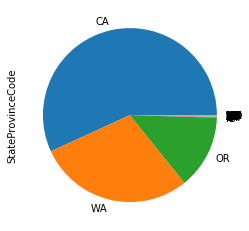

In [54]:
df['StateProvinceCode'].value_counts().plot.pie()

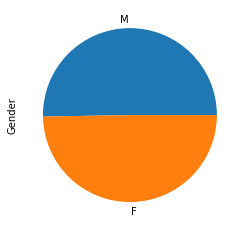

In [55]:
df['Gender'].value_counts().plot.pie()

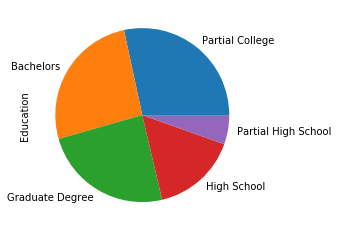

In [56]:
df['Education'].value_counts().plot.pie()

#### Target

In [14]:
df['BikeBuyer'].value_counts()

0    4250
1    3569
Name: BikeBuyer, dtype: int64

## Train on a "local" VM target (current compute instance used within this browser)

#### Create new folder

In [60]:
import os
script_folder = os.path.join(os.getcwd(), "sklearn-bikebuyer")
os.makedirs(script_folder, exist_ok=True)

#### Create train.py file

In [85]:
%%writefile $script_folder/train.py

import os
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from category_encoders import OneHotEncoder
from azureml.core import Run, Workspace, Datastore, Dataset


# get existing workspace
workspace = Workspace.from_config()  #config file is already saved locally when using this interface

dataset = Dataset.get_by_name(workspace, name='BikeBuyerTraining')
df=dataset.to_pandas_dataframe()

#Create input matrix and target vec
X=df.drop(['BikeBuyer','PostalCode'],axis=1).values
y=df['BikeBuyer'].values

#One Hot Encoding
ohe=OneHotEncoder(use_cat_names=True)
X_ohe=ohe.fit_transform(X).fillna(0)


#Data Partition
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)

for train_index, test_index in sss.split(X_ohe, y):
    X_train, X_test = X_ohe.iloc[train_index], X_ohe.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, sep = '\n')

print('Train a logistic regression model')
clf = LogisticRegression(random_state=87)
clf.fit(X_train, y_train)

print('Predict the test set')
y_hat = clf.predict(X_test)

# calculate accuracy on the prediction
acc = np.average(y_hat == y_test)
print('Accuracy is', acc)

os.makedirs('outputs', exist_ok=True)
model_dict={"model":clf,"ohe":ohe}
# note file saved in the outputs folder is automatically uploaded into experiment record
joblib.dump(value=model_dict, filename='outputs/sklearn_bikebuyer_model.pkl')
joblib.dump(value=ohe, filename='outputs/sklearn_bikebuyer_ohe.pkl')

Overwriting /mnt/batch/tasks/shared/LS_root/mounts/clusters/aiadjacent/code/users/anfrankl/image-classification-mnist-data/sklearn-bikebuyer/train.py


### Configure Compute Target (local_run)

In [86]:
from azureml.core.runconfig import RunConfiguration

# Edit a run configuration property on the fly.
run_local = RunConfiguration()

run_local.environment.python.user_managed_dependencies = True

In [87]:
from azureml.core import ScriptRunConfig
import os 

src = ScriptRunConfig(source_directory = script_folder, script = 'train.py', run_config = run_local)
run = exp.submit(src)
run.wait_for_completion(show_output = True)

RunId: sklearn-bikebuyer_1583234142_c0135af6
Web View: https://ml.azure.com/experiments/sklearn-bikebuyer/runs/sklearn-bikebuyer_1583234142_c0135af6?wsid=/subscriptions/e1eb783d-78a5-42a4-bae3-bc0ddd433898/resourcegroups/robotairg/workspaces/aiadjacent

Streaming azureml-logs/60_control_log.txt

Streaming log file azureml-logs/60_control_log.txt
Starting the daemon thread to refresh tokens in background for process with pid = 124345
Running: ['/bin/bash', '/tmp/azureml_runs/sklearn-bikebuyer_1583234142_c0135af6/azureml-environment-setup/conda_env_checker.sh']


Running: ['python', 'azureml-setup/run_script.py', 'python', 'azureml-setup/context_manager_injector.py', '-i', 'ProjectPythonPath:context_managers.ProjectPythonPath', '-i', 'RunHistory:context_managers.RunHistory', '-i', 'TrackUserError:context_managers.TrackUserError', '-i', 'UserExceptions:context_managers.UserExceptions', 'train.py']
Logging experiment running status in history service.
Streaming log file azureml-logs/70_dri

{'runId': 'sklearn-bikebuyer_1583234142_c0135af6',
 'target': 'local',
 'status': 'Completed',
 'startTimeUtc': '2020-03-03T11:15:44.854482Z',
 'endTimeUtc': '2020-03-03T11:15:56.95202Z',
 'properties': {'_azureml.ComputeTargetType': 'local',
  'ContentSnapshotId': 'ed1edaa5-504d-422d-bf4c-cfa9b2966b26'},
 'inputDatasets': [{'dataset': {'id': 'e8dbad55-816e-466a-afb4-be685546f81e'}, 'consumptionDetails': {'type': 'Reference'}}],
 'runDefinition': {'script': 'train.py',
  'useAbsolutePath': False,
  'arguments': [],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'local',
  'dataReferences': {},
  'data': {},
  'jobName': None,
  'maxRunDurationSeconds': None,
  'nodeCount': 1,
  'environment': {'name': 'Experiment sklearn-bikebuyer Environment',
   'version': 'Autosave_2020-03-03T10:17:20Z_d573854a',
   'python': {'interpreterPath': 'python',
    'userManagedDependencies': True,
    'condaDependencies': {'channels': ['conda-forge'],
  

In the next tutorial you will explore this model in more detail.

## Register model

The last step in the training script wrote the file `outputs/sklearn_mnist_model.pkl` in a directory named `outputs` in the VM of the cluster where the job is executed. `outputs` is a special directory in that all content in this  directory is automatically uploaded to your workspace.  This content appears in the run record in the experiment under your workspace. Hence, the model file is now also available in your workspace.

You can see files associated with that run.

In [88]:
print(run.get_file_names())

['azureml-logs/60_control_log.txt', 'azureml-logs/70_driver_log.txt', 'logs/azureml/124358_azureml.log', 'outputs/sklearn_bikebuyer_model.pkl', 'outputs/sklearn_bikebuyer_ohe.pkl']


Register the model in the workspace so that you (or other collaborators) can later query, examine, and deploy this model.

In [89]:
# register model 
model = run.register_model(model_name='sklearn_bikebuyer', model_path='outputs/sklearn_bikebuyer_model.pkl')
print(model.name, model.id, model.version, sep='\t')

sklearn_bikebuyer	sklearn_bikebuyer:4	4


## Next steps

In this Azure Machine Learning tutorial, you used Python to:

> * Set up your development environment
> * Access and examine the data
> * Train multiple models on a remote cluster using the popular scikit-learn machine learning library
> * Review training details and register the best model

You are ready to deploy this registered model using the instructions in the next part of the tutorial series:

> [Tutorial 2 - Deploy models](img-classification-part2-deploy.ipynb)

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/NotebookVM/tutorials/img-classification-part1-training.png)